In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv, GCNConv
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
#GAT Model Definition

class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=8):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=1)
        
    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [3]:
# GCN Model Definition
class GCNNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [4]:
#Training Function
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


In [5]:
# Evaluation Function
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
    return acc


In [6]:
#   Model Training Function
def train_model(model, data, model_name, num_epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    training_times = []
    
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        loss = train(model, data, optimizer, criterion)
        train_losses.append(loss)
        
        if epoch % 10 == 0:
            val_acc = evaluate(model, data, data.val_mask)
            val_accuracies.append(val_acc)
            epoch_time = time.time() - epoch_start
            training_times.append(epoch_time)
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s')
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pt')
    
    total_time = time.time() - start_time
    print(f"\n{model_name} Training completed in {total_time:.2f} seconds")
    
    return train_losses, val_accuracies, training_times

In [7]:
# Load Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
    

In [8]:
# Model parameters
in_channels = dataset.num_node_features
hidden_channels = 8
out_channels = dataset.num_classes

# Initialize models
gat_model = GATNet(in_channels, hidden_channels, out_channels)
gcn_model = GCNNet(in_channels, hidden_channels, out_channels)

# Train models
gat_losses, gat_accs, gat_times = train_model(gat_model, data, "GAT")
gcn_losses, gcn_accs, gcn_times = train_model(gcn_model, data, "GCN")

# Evaluate final performance
gat_model.load_state_dict(torch.load('best_gat_model.pt'))
gcn_model.load_state_dict(torch.load('best_gcn_model.pt'))

gat_test_acc = evaluate(gat_model, data, data.test_mask)
gcn_test_acc = evaluate(gcn_model, data, data.test_mask)

print("\nFinal Test Accuracies:")
print(f"GAT: {gat_test_acc:.4f}")
print(f"GCN: {gcn_test_acc:.4f}")



Training GAT...
Epoch 000, Loss: 1.9748, Val Acc: 0.4800, Time: 0.05s
Epoch 010, Loss: 0.3746, Val Acc: 0.7780, Time: 0.04s
Epoch 020, Loss: 0.0756, Val Acc: 0.8000, Time: 0.03s
Epoch 030, Loss: 0.0156, Val Acc: 0.7800, Time: 0.04s
Epoch 040, Loss: 0.0128, Val Acc: 0.7720, Time: 0.04s
Epoch 050, Loss: 0.0082, Val Acc: 0.7680, Time: 0.04s
Epoch 060, Loss: 0.0090, Val Acc: 0.7660, Time: 0.04s
Epoch 070, Loss: 0.0104, Val Acc: 0.7680, Time: 0.04s
Epoch 080, Loss: 0.0118, Val Acc: 0.7680, Time: 0.04s
Epoch 090, Loss: 0.0096, Val Acc: 0.7660, Time: 0.04s
Epoch 100, Loss: 0.0114, Val Acc: 0.7700, Time: 0.04s
Epoch 110, Loss: 0.0092, Val Acc: 0.7620, Time: 0.03s
Epoch 120, Loss: 0.0105, Val Acc: 0.7660, Time: 0.04s
Epoch 130, Loss: 0.0111, Val Acc: 0.7660, Time: 0.04s
Epoch 140, Loss: 0.0100, Val Acc: 0.7680, Time: 0.04s
Epoch 150, Loss: 0.0090, Val Acc: 0.7680, Time: 0.04s
Epoch 160, Loss: 0.0071, Val Acc: 0.7580, Time: 0.04s
Epoch 170, Loss: 0.0090, Val Acc: 0.7440, Time: 0.04s
Epoch 180, 

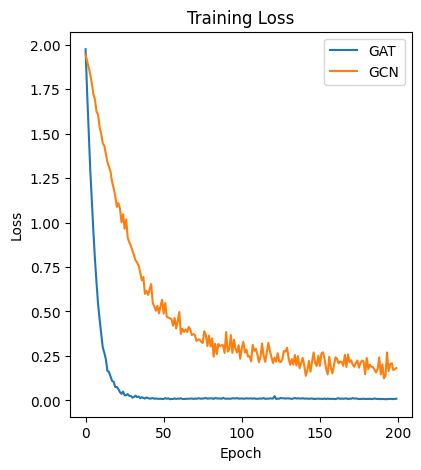

In [10]:
# Plot comparison
plt.figure(figsize=(15, 5))

# Plot training losses
plt.subplot(1, 3, 1)
plt.plot(gat_losses, label='GAT')
plt.plot(gcn_losses, label='GCN')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

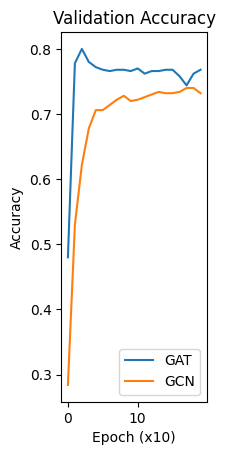

In [11]:
# Plot validation accuracies
plt.subplot(1, 3, 2)
plt.plot(gat_accs, label='GAT')
plt.plot(gcn_accs, label='GCN')
plt.title('Validation Accuracy')
plt.xlabel('Epoch (x10)')
plt.ylabel('Accuracy')
plt.legend()


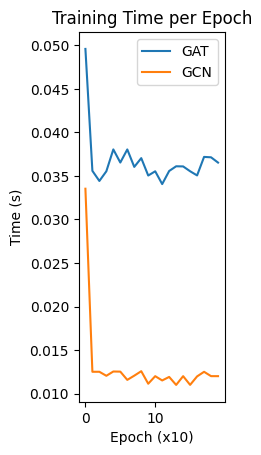

In [13]:
# Plot training times
plt.subplot(1, 3, 3)
plt.plot(gat_times, label='GAT')
plt.plot(gcn_times, label='GCN')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch (x10)')
plt.ylabel('Time (s)')
plt.legend()



In [14]:

# Print model statistics
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nModel Statistics:")
print(f"GAT Parameters: {count_parameters(gat_model):,}")
print(f"GCN Parameters: {count_parameters(gcn_model):,}")

print("\nAverage Training Time per Epoch:")
print(f"GAT: {np.mean(gat_times):.2f}s")
print(f"GCN: {np.mean(gcn_times):.2f}s")



Model Statistics:
GAT Parameters: 92,373
GCN Parameters: 11,535

Average Training Time per Epoch:
GAT: 0.04s
GCN: 0.01s
